#Librerias

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

#Funciones

## Difracción Computacional por Espectro Angular

En este bloque implementaremos una función en Python (Colab) que simula la **propagación de un campo óptico en el espacio libre** usando el método del **Espectro Angular**.  

El procedimiento sigue los pasos teóricos mostrados en la formulación:

1. Tomar o generar el campo inicial \( U[n,m,0] \).  
2. Calcular su transformada de Fourier \( A[p,q,0] \).  
3. Aplicar el factor de propagación para obtener \( A[p,q,z] \).  
4. Regresar al dominio espacial mediante la transformada inversa (IFFT).  
5. Reordenar el campo (shift) para visualizar correctamente el resultado.  

De esta forma, podremos propagar cualquier distribución inicial de amplitud y fase a una distancia \( z \) determinada, considerando la longitud de onda y la discretización espacial.


In [ ]:
import numpy as np
import cv2

def fft_propagacion_espectro_angular(
    campo_inicial: np.ndarray,
    nx: int,
    ny: int,
    x_min: float,
    x_max: float,
    distancia_z: float,
    lambda_: float,
    y_min: float = None,
    y_max: float = None
    )-> np.ndarray:
    """
    Calcula la propagación de un campo óptico en el espacio libre usando
    el método del espectro angular basado en la FFT.

    Parameters
    ----------
    campo_inicial : np.ndarray
        Campo complejo 2D (amplitud y fase) en el plano inicial (z=0). Puede ser una imagen en escala de grises.

    nx, ny : int
        Número de puntos de muestreo en las direcciones x e y. Definen la resolución de la cuadrícula de simulación.

    x_min, x_max : float
        Límites físicos del eje x en el plano inicial (ej. en milímetros).

    distancia_z : float
        Distancia de propagación a lo largo del eje z.

    lambda_ : float
        Longitud de onda del campo óptico en las mismas unidades que los límites espaciales.

    y_min, y_max : float, opcional
        Límites físicos del eje y. Si no se especifican, se asume que son iguales a los de x (x_min, x_max).

    Returns
    -------
    np.ndarray
        Intensidad del campo propagado a la distancia z.

    Raises
    ------
    ValueError
        Si los parámetros de entrada no son físicamente válidos.
    """
    # Si no se especifica y_min y y_max, usaremos los mismos valores de x_min y x_max
    if y_min is None: y_min = x_min
    if y_max is None: y_max = x_max

    # Verificación de posibles errores
    if lambda_ <= 0:
        raise ValueError("lambda debe ser mayor que cero")

    if distancia_z <= 0:
        raise ValueError("distancia_z debe ser mayor que cero")

    if nx <= 0 or ny <= 0:
        raise ValueError("nx y ny deben ser mayores que cero")

    if x_min >= x_max or y_min >= y_max:
        raise ValueError("x_min debe ser menor que x_max y y_min debe ser menor que y_max")

    # Verificar o transformar a escala de grises
    if len(campo_inicial.shape) == 3:
        campo_inicial = cv2.cvtColor(campo_inicial, cv2.COLOR_BGR2GRAY)
    elif len(campo_inicial.shape) == 2:
        pass
    else:
        raise ValueError("El campo inicial tiene una forma inesperada")

    campo_inicial = campo_inicial.astype(np.float64)

    # Redimensionar para que concuerde con la cantidad de muestras
    campo_inicial = cv2.resize(campo_inicial, (nx, ny), interpolation=cv2.INTER_AREA)

    # Normalizar el campo inicial
    campo_inicial = campo_inicial / 255.0

    # Calcular los pasos espaciales
    dx = (x_max - x_min) / nx  # Corregido: usar nx en lugar de (nx-1)
    dy = (y_max - y_min) / ny  # Corregido: usar ny en lugar de (ny-1)

    # Calcular las frecuencias espaciales
    fx = np.fft.fftfreq(nx, d=dx)
    fy = np.fft.fftfreq(ny, d=dy)
    FX, FY = np.meshgrid(fx, fy, indexing='ij')

    # Verificar la condición de muestreo adecuado (segunda imagen)
    # z <= M * (Δx)^2 / λ, donde M es el número de muestras y Δx es el tamaño del píxel
    M_efectivo = min(nx, ny)
    delta_x_max = max(dx, dy)  # Usamos el paso espacial más grande (más restrictivo)

    z_max_permitido = M_efectivo * (delta_x_max**2) / lambda_

    if distancia_z > z_max_permitido:
        print(f"La distancia z={distancia_z} excede el límite para evitar aliasing. "
                        f"Máximo permitido: z_max = {z_max_permitido:.6f}")

    print(f"Criterio de muestreo: z_max = {z_max_permitido:.6f}, z_actual = {distancia_z}")

    # FFT del campo inicial (ecuación A[p,q,0] = ...)
    A_pq_0 = np.fft.fft2(campo_inicial)

    # Función de transferencia del espectro angular
    # A[p,q,z] = A[p,q,0] * exp(i*z*k*sqrt(1-(λΔf)^2*(p^2+q^2)))
    k = 2 * np.pi / lambda_

    # Calcular el término bajo la raíz: 1 - (λ*fx)^2 - (λ*fy)^2
    termino_raiz = 1 - (lambda_ * FX)**2 - (lambda_ * FY)**2

    # Filtrar ondas evanescentes (cuando el término bajo la raíz es negativo)
    mascara_propagantes = termino_raiz >= 0

    # Calcular la función de transferencia solo para ondas propagantes
    transferencia = np.zeros_like(termino_raiz, dtype=complex)
    transferencia[mascara_propagantes] = np.exp(
        1j * distancia_z * k * np.sqrt(termino_raiz[mascara_propagantes])
    )

    # Aplicar la función de transferencia
    A_pq_z = A_pq_0 * transferencia

    # IFFT para obtener el campo propagado (ecuación U[n,m,z] = ...)
    campo_propagado = np.fft.ifft2(A_pq_z)

    # Calcular la intensidad (|U|^2) y normalizar
    intensidad_propagada = np.abs(campo_propagado)**2

    # Normalizar al máximo
    if np.max(intensidad_propagada) > 0:
        intensidad_propagada = intensidad_propagada / np.max(intensidad_propagada)

    return intensidad_propagada

## Difracción Computacional por Transformada de Fresnel

A continuacion este bloque implementaremos una nuevafunción en Python (Colab) que simula la **propagación de un campo óptico en el espacio libre** con la diferencia de que ahora usaremos el metodo de la **Tranformada de Fresnel**.  

El procedimiento sigue los pasos teóricos mostrados en la formulación:

1. Tomar o generar el campo inicial \( U[n,m,0] \).  
2. Calcular su transformada de Fourier \( F0[p,q,0] \).  
3. Aplicar la Función de transferencia para la propagación de Fresnel y obtener \( F[p,q,z] \).  
4. Regresar al dominio espacial mediante la transformada inversa (IFFT).  
5. Reordenar el campo (shift) para visualizar correctamente el resultado.  

De esta forma, podremos propagar cualquier distribución inicial de amplitud y fase a una distancia z (con una condicion minima de valor de z) determinada, considerando la longitud de onda y la discretización espacial.


In [ ]:
#@title #Propagacion Transformada de Fresnel-FFT
def fft_propagacion_transformada_fresnel(
    campo_inicial: np.ndarray,
    nx: int,
    ny: int,
    x_min: float,
    x_max: float,
    distancia_z: float,
    lambda_: float,
    y_min: float = None,
    y_max: float = None
) -> np.ndarray:
    """
    Calcula la propagación de un campo óptico en el espacio libre usando
    la aproximación de Fresnel mediante el método de convolución basado en FFT.

    Parameters
    ----------
    campo_inicial : np.ndarray
        Campo complejo 2D (amplitud y fase) en el plano inicial (z=0).
        Puede ser una imagen en escala de grises.

    nx, ny : int
        Número de puntos de muestreo en las direcciones x e y. Definen la
        resolución de la cuadrícula de simulación.

    x_min, x_max : float
        Límites físicos del eje x en el plano inicial (ej. en milímetros).

    distancia_z : float
        Distancia de propagación a lo largo del eje z.

    lambda_ : float
        Longitud de onda del campo óptico en las mismas unidades que los
        límites espaciales.

    y_min, y_max : float, optional
        Límites físicos del eje y. Si no se especifican, se asume que son
        iguales a los de x (x_min, x_max).

    Returns
    -------
    np.ndarray
        Intensidad del campo propagado a la distancia z.

    Raises
    ------
    ValueError
        Si los parámetros de entrada no son físicamente válidos.
    """
    # Si no se especifica y_min y y_max, usaremos los mismos valores de x_min y x_max
    if y_min is None: y_min = x_min
    if y_max is None: y_max = x_max

    # Verificación de posibles errores
    if lambda_ <= 0:
        raise ValueError("lambda debe ser mayor que cero")

    if nx <= 0 or ny <= 0:
        raise ValueError("nx y ny deben ser mayores que cero")

    if x_min >= x_max or y_min >= y_max:
        raise ValueError("x_min debe ser menor que x_max y y_min debe ser menor que y_max")

    if distancia_z <= 0:
        raise ValueError("La distancia de propagación debe ser mayor que cero")

    # Verificar o transformar a escala de grises
    if len(campo_inicial.shape) == 3:
        campo_inicial = cv2.cvtColor(campo_inicial, cv2.COLOR_BGR2GRAY)
    elif len(campo_inicial.shape) != 2:
        raise ValueError("El campo inicial tiene una forma inesperada")

    # Asegurar que el campo de entrada tenga el tamaño correcto
    if campo_inicial.shape != (ny, nx):
         campo_inicial = cv2.resize(campo_inicial, (nx, ny), interpolation=cv2.INTER_AREA)

    campo_inicial = campo_inicial.astype(np.complex128)  # Usar complex128 para mayor precisión

    # Calcular el tamaño del píxel (Δx y Δy)
    dx = (x_max - x_min) / (nx - 1)
    dy = (y_max - y_min) / (ny - 1)

    # RESTRICCIÓN DE FRECUENCIAS ESPACIALES (Condición de validez de Fresnel)
    # z >= M*Δx²/λ donde M es el número de muestras
    min_z_x = nx * dx**2 / lambda_
    min_z_y = ny * dy**2 / lambda_
    min_z_required = max(min_z_x, min_z_y)

    if distancia_z < min_z_required:
        print(f"ADVERTENCIA: La distancia z={distancia_z:.6f} es menor que la mínima requerida z_min={min_z_required:.6f}")
        print(f"Esto puede causar aliasing en las frecuencias espaciales.")
        print(f"Para evitar errores, use z >= {min_z_required:.6f}")

    # Paso 1: U'[n₀, m₀, 0] - Aplicar la fase cuadrática inicial
    # Coordenadas espaciales centradas
    x = np.linspace(x_min, x_max, nx)
    y = np.linspace(y_min, y_max, ny)
    X, Y = np.meshgrid(x, y, indexing='ij')

    # Factor de fase cuadrática inicial: exp(jk/(2z)(n₀Δx₀)²+(m₀Δy₀)²)
    k = 2 * np.pi / lambda_
    fase_inicial = np.exp(1j * k / (2 * distancia_z) * (X**2 + Y**2))
    U_prime_0 = campo_inicial * fase_inicial

    # Paso 2: U''[n, m, z] - FFT de U'[n₀, m₀, 0]
    # El factor (Δz)² se incluye implícitamente en la normalización de la FFT
    delta_z_factor = (dx * dy) / (1j * lambda_ * distancia_z)
    U_double_prime = delta_z_factor * np.fft.fft2(U_prime_0)

    # Paso 3: U[n, m, z] - Aplicar la fase cuadrática final
    # Coordenadas de frecuencia espacial en el plano de salida
    # Para mantener consistencia con las ecuaciones, usamos las mismas coordenadas espaciales
    # pero ahora representan las coordenadas en el plano z
    fase_final = np.exp(1j * k / (2 * distancia_z) * (X**2 + Y**2))
    campo_propagado = (fase_final * U_double_prime)

    # Aplicar fftshift para centrar correctamente el resultado
    campo_propagado = np.fft.fftshift(campo_propagado)

    # Calcular la intensidad y normalizar
    intensidad = np.abs(campo_propagado)**2
    intensidad = intensidad / np.max(intensidad)

    return intensidad

#Visualización

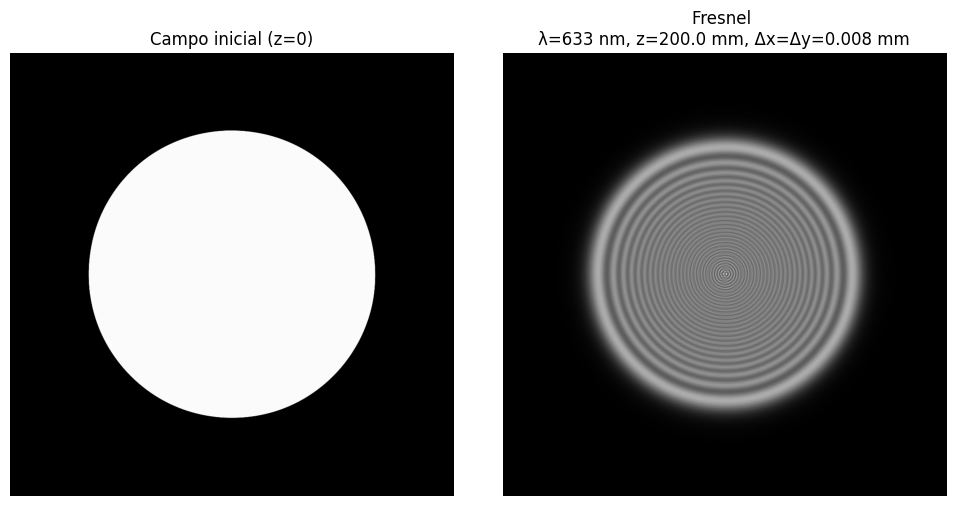

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# --- Parámetros físicos en MILÍMETROS ---
lambda_mm = 0.000633   # 633 nm
z_mm = 200.0           # 0.20 m
dx_mm = dy_mm = 0.008  # 8 µm

# --- Cargar imagen (escala de grises 2D) ---
img_path = "/content/Rendija_circular.png"
campo0 = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
if campo0 is None:
    raise FileNotFoundError(f"No se encontró la imagen en: {img_path}")

# Normaliza a [0,1]
campo0 = campo0.astype(np.float64) / 255.0

# --- Tamaños y límites físicos coherentes con el muestreo ---
ny, nx = campo0.shape
Lx_mm = nx * dx_mm
Ly_mm = ny * dy_mm
x_min, x_max = -Lx_mm/2, Lx_mm/2
y_min, y_max = -Ly_mm/2, Ly_mm/2

# Importante: tu función arma mallas con indexing="ij" (formas (nx, ny)).
# Para que multiplique sin error, pasamos el campo como (nx, ny):
campo0_for_fn = campo0.T  # (ny, nx) -> (nx, ny)

# --- Llamada a tu función (devuelve intensidad normalizada) ---
Iz = fft_propagacion_transformada_fresnel(
    campo_inicial=campo0_for_fn,
    nx=nx,
    ny=ny,
    x_min=x_min,
    x_max=x_max,
    distancia_z=z_mm,
    lambda_=lambda_mm,
    y_min=y_min,
    y_max=y_max
)

# --- Visualización: original vs propagada ---
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(campo0, cmap="gray")
plt.title("Campo inicial (z=0)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(Iz, cmap="gray")
plt.title(f"Fresnel \nλ=633 nm, z={z_mm} mm, Δx=Δy={dx_mm:.3f} mm")
plt.axis("off")
plt.tight_layout()
plt.show()


La distancia z=0.25 excede el límite para evitar aliasing. Máximo permitido: z_max = 0.097264
Criterio de muestreo: z_max = 0.097264, z_actual = 0.25


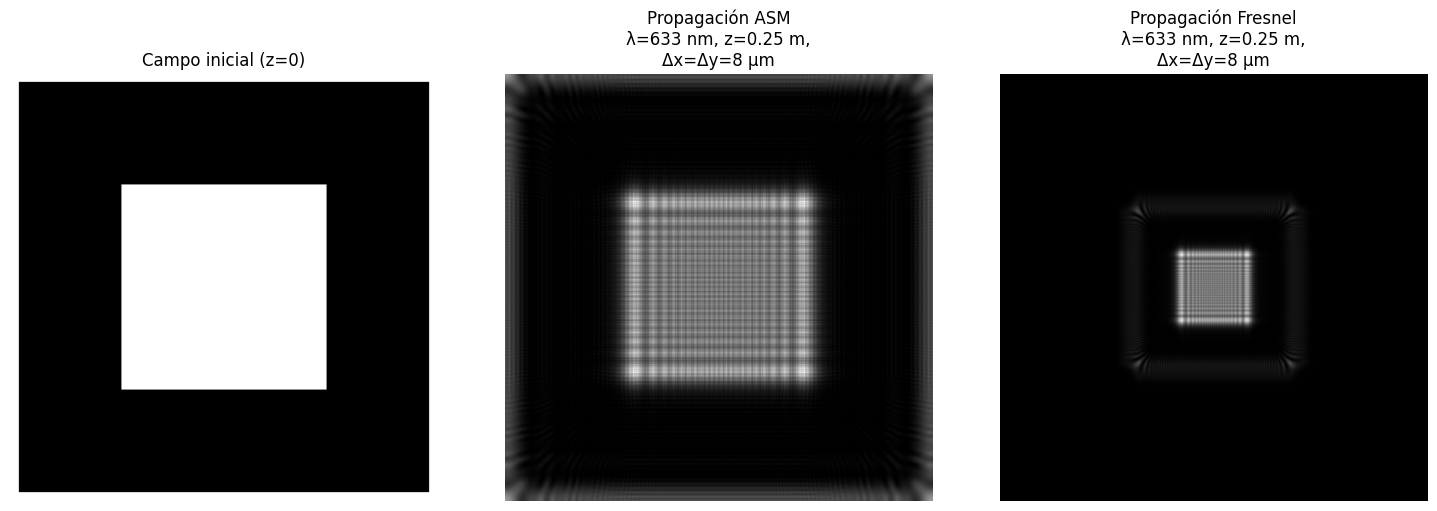

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# --- Parámetros físicos ---
lambda_ = 633e-9        # Longitud de onda (633 nm, en metros)
z = 0.25    # Distancia de propagación (m)
dx = dy = 8e-6           # Paso de muestreo (m)

# --- Cargar imagen ---
img_path = "/content/output (1).png"
campo0 = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
if campo0 is None:
    raise FileNotFoundError(f"No se encontró la imagen en {img_path}")

campo0 = campo0.astype(np.float64) / 255.0

# --- Dimensiones y límites espaciales ---
ny, nx = campo0.shape
Lx = (nx - 1) * dx
Ly = (ny - 1) * dy
x_min, x_max = -Lx/2, Lx/2
y_min, y_max = -Ly/2, Ly/2

# --- Llamada a tu AS ---
Iz = fft_propagacion_espectro_angular(
    campo_inicial=campo0,
    nx=nx,
    ny=ny,
    x_min=x_min,
    x_max=x_max,
    distancia_z=z,
    lambda_=lambda_,
    y_min=y_min,
    y_max=y_max
)
# --- Llamada a tu AS ---
IzF = fft_propagacion_transformada_fresnel(
    campo_inicial=campo0,
    nx=nx,
    ny=ny,
    x_min=x_min,
    x_max=x_max,
    distancia_z=z,
    lambda_=lambda_,
    y_min=y_min,
    y_max=y_max
)


# --- Visualización de 3 imágenes ---
plt.figure(figsize=(15,5))

# Imagen 1
plt.subplot(1, 3, 1)
plt.imshow(campo0, cmap="gray")
plt.title("Campo inicial (z=0)")
plt.axis("off")

# Imagen 2
plt.subplot(1, 3, 2)
plt.imshow(Iz, cmap="gray")
plt.title(f"Propagación ASM\nλ=633 nm, z={z} m,\nΔx=Δy={dx*1e6:.0f} µm")
plt.axis("off")

# Imagen 3
plt.subplot(1, 3, 3)
plt.imshow(IzF, cmap="gray")
plt.title(f"Propagación Fresnel\nλ=633 nm, z={z} m,\nΔx=Δy={dx*1e6:.0f} µm")
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
def crear_rejilla_ronchi(
    tamano_px=1024,
    tamano_fisico_mm=10.0,
    pares_lineas_por_mm=10
):
    """
    Genera una matriz 2D que representa una rejilla Ronchi.
    """
    periodo_mm = 1.0 / pares_lineas_por_mm
    px_por_mm = tamano_px / tamano_fisico_mm
    periodo_px = periodo_mm * px_por_mm

    # Generar un patrón de onda cuadrada 1D
    x = np.arange(tamano_px)
    patron_1d = ((x % periodo_px) < (periodo_px / 2)).astype(float)

    # Extender el patrón 1D a una imagen 2D
    rejilla = np.tile(patron_1d, (tamano_px, 1))
    return rejilla


In [ ]:
lambda_mm = 633 * 1e-6      # Longitud de onda en mm (633 nm)
tamano_fisico_mm = 10.0     # Ancho físico de la rejilla en mm
x_min, x_max = -tamano_fisico_mm / 2, tamano_fisico_mm / 2
pares_lineas_por_mm = 10.0  # Frecuencia espacial de la rejilla
nx, ny = 1024, 1024         # Resolución de la simulación

nombre_archivo = 'rejilla_ronchi.png'
rejilla_inicial = crear_rejilla_ronchi(
     tamano_px=nx,
     tamano_fisico_mm=tamano_fisico_mm,
     pares_lineas_por_mm=pares_lineas_por_mm
    )

plt.imsave(nombre_archivo, rejilla_inicial, cmap='gray')


In [ ]:
#@title Creación de imagen de prueba 2.9
import numpy as np
import matplotlib.pyplot as plt

def crear_rejilla_ronchi(
    tamano_px=1024,
    tamano_fisico_mm=10.0,
    pares_lineas_por_mm=0.001
):
    """
    Genera una matriz 2D que representa una rejilla Ronchi.
    """
    periodo_mm = 1.0 / pares_lineas_por_mm
    px_por_mm = tamano_px / tamano_fisico_mm
    periodo_px = periodo_mm * px_por_mm

    # Generar un patrón de onda cuadrada 1D
    x = np.arange(tamano_px)
    patron_1d = ((x % periodo_px) < (periodo_px / 2)).astype(float)

    # Extender el patrón 1D a una imagen 2D
    rejilla = np.tile(patron_1d, (tamano_px, 1))

    return rejilla

# --- Parámetros de la rejilla ---
PARES_DE_LINEAS_POR_MM = 10

# --- Generar la matriz de la rejilla ---
rejilla_matriz = crear_rejilla_ronchi(
    pares_lineas_por_mm=PARES_DE_LINEAS_POR_MM
)

# --- Guardar la matriz como imagen PNG en escala de grises ---
nombre_archivo = 'rejilla_ronchi.png'
plt.imsave(nombre_archivo, rejilla_matriz, cmap='gray')

print(f"Imagen '{nombre_archivo}' guardada correctamente.")

Imagen 'rejilla_ronchi.png' guardada correctamente.


Propagando a una distancia z = 15.80 mm (Z_T/2)
Criterio de muestreo: z_max = 154.275276, z_actual = 15.797788309636655


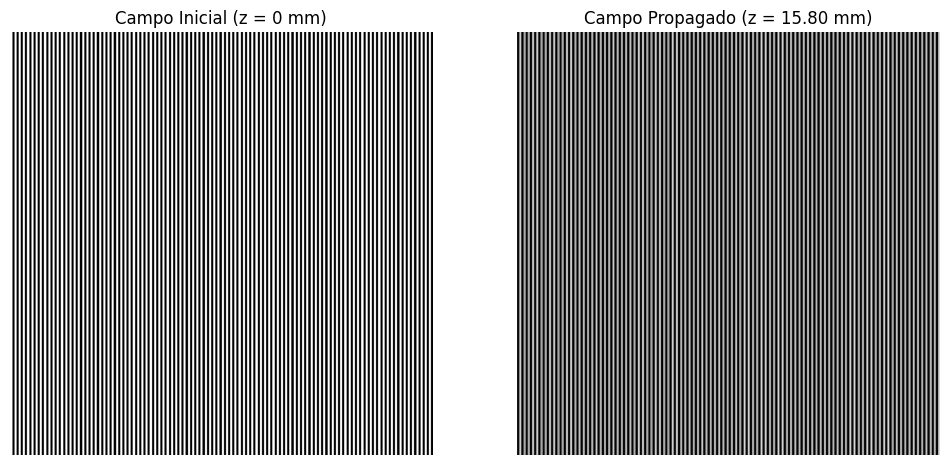

In [ ]:
rejilla_inicial = cv2.imread('rejilla_ronchi.png', cv2.IMREAD_GRAYSCALE)

if rejilla_inicial is None:
    print("Error: No se pudo cargar la imagen. Asegúrate de que 'rejilla_ronchi.png' esté en la carpeta correcta.")
else:
    rejilla_inicial = rejilla_inicial / 255.0 # Normalizar a [0, 1]

    lambda_mm = 633 * 1e-6      # Longitud de onda en mm (633 nm)
    tamano_fisico_mm = 10.0     # Ancho físico de la rejilla en mm
    x_min, x_max = -tamano_fisico_mm / 2, tamano_fisico_mm / 2
    ny, nx = rejilla_inicial.shape

    periodo_rejilla_mm = 1.0 / 10.0  # Periodo para 10 lp/mm
    distancia_talbot = (2 * periodo_rejilla_mm**2) / lambda_mm
    distancia_z = distancia_talbot/2


    print(f"Propagando a una distancia z = {distancia_z:.2f} mm (Z_T/2)")

    campo_final = fft_propagacion_espectro_angular(
        campo_inicial=rejilla_inicial,
        nx=nx,
        ny=ny,
        x_min=x_min,
        x_max=x_max,
        distancia_z=distancia_z,
        lambda_=lambda_mm
    )

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.imshow(rejilla_inicial, cmap='gray')
    ax1.set_title("Campo Inicial (z = 0 mm)")
    ax1.axis('off')

    ax2.imshow(campo_final, cmap='gray')
    ax2.set_title(f"Campo Propagado (z = {distancia_z:.2f} mm)")
    ax2.axis('off')

    plt.show()

##Punto 3

Iniciando simulación de difracción...
Objeto: 'Transm_E04.png', Tamaño físico: 5.8 mm
Distancias a calcular: ['100.0 mm', '175.0 mm', '250.0 mm', '325.0 mm', '400.0 mm']

Distancia límite para usar Fresnel: z >= 57.64 mm

Calculando patrón para z = 100.0 mm...
  -> Usando Transformada de Fresnel (z >= 57.64 mm)

Calculando patrón para z = 175.0 mm...
  -> Usando Transformada de Fresnel (z >= 57.64 mm)

Calculando patrón para z = 250.0 mm...
  -> Usando Transformada de Fresnel (z >= 57.64 mm)

Calculando patrón para z = 325.0 mm...
  -> Usando Transformada de Fresnel (z >= 57.64 mm)

Calculando patrón para z = 400.0 mm...
  -> Usando Transformada de Fresnel (z >= 57.64 mm)


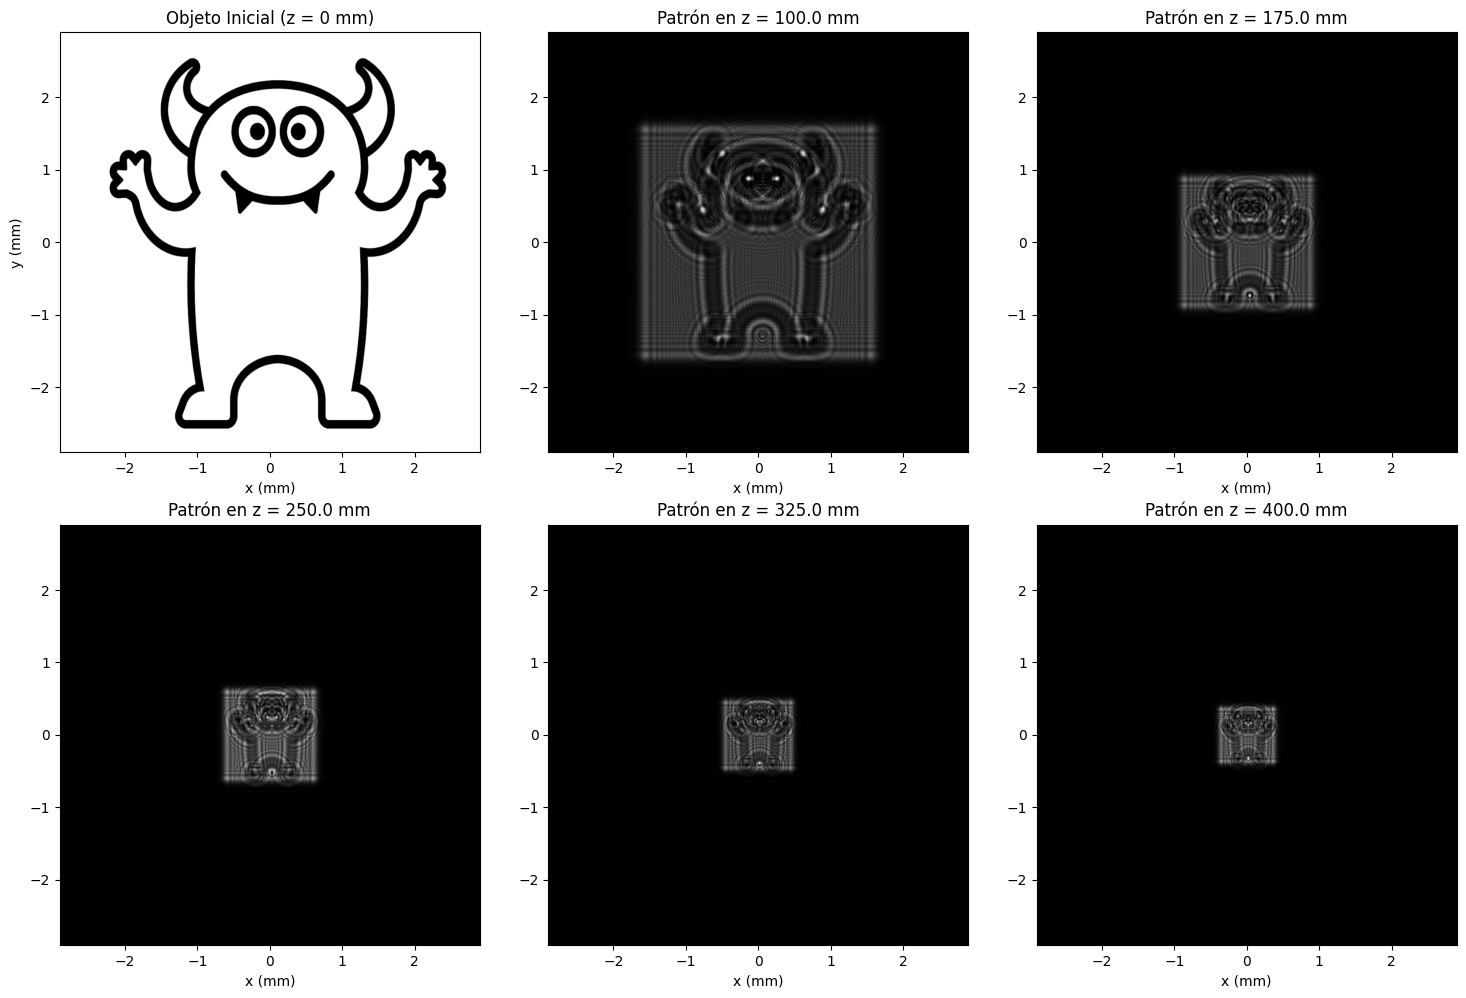

In [ ]:

# --- 1. Parámetros de la simulación ---
# Nombre del archivo que contiene la transmitancia del objeto.
nombre_archivo_objeto = 'Transm_E04.png'
# Longitud de onda en milímetros (633 nm -> 633e-6 mm).
lambda_mm = 633e-6
# Dimensión física transversal del objeto en milímetros.
tamano_fisico_mm = 5.8

# --- 2. Cargar y preparar el objeto (campo inicial) ---
# Cargar la imagen en escala de grises.
campo_inicial = cv2.imread(nombre_archivo_objeto, cv2.IMREAD_GRAYSCALE)

# Verificar si la imagen se cargó correctamente.
if campo_inicial is None:
    raise FileNotFoundError(f"Error: No se pudo cargar la imagen '{nombre_archivo_objeto}'.")

# Normalizar la imagen para que sus valores estén entre 0 y 1.
campo_inicial = campo_inicial / 255.0

# Obtener las dimensiones de la simulación a partir de la imagen.
ny, nx = campo_inicial.shape
# Definir los límites del espacio físico.
x_min, x_max = -tamano_fisico_mm / 2, tamano_fisico_mm / 2
y_min, y_max = -tamano_fisico_mm / 2, tamano_fisico_mm / 2

# --- 3. Definir las distancias de propagación ---
# Se crearán 5 distancias espaciadas uniformemente entre 10 cm (100 mm) y 40 cm (400 mm).
distancias_mm = np.linspace(100, 400, 5)

print("Iniciando simulación de difracción...")
print(f"Objeto: '{nombre_archivo_objeto}', Tamaño físico: {tamano_fisico_mm} mm")
print("Distancias a calcular:", [f"{d:.1f} mm" for d in distancias_mm])

# --- 4. Preparar la figura para las gráficas ---
# Se crea una figura con 2 filas y 3 columnas para mostrar 6 imágenes.
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
# Se aplana el array de ejes para acceder a ellos como una lista (axes[0], axes[1], ...).
axes = axes.ravel()

# --- 5. Graficar el objeto inicial ---
# Mostrar la imagen original en el primer subplot.
axes[0].imshow(campo_inicial, cmap='gray', extent=[x_min, x_max, y_min, y_max])
axes[0].set_title("Objeto Inicial (z = 0 mm)")
axes[0].set_xlabel("x (mm)")
axes[0].set_ylabel("y (mm)")

# --- 6. Bucle para calcular y graficar la difracción en cada distancia ---
# Calcular el tamaño del píxel (delta_x)
dx = tamano_fisico_mm / nx
# Calcular la distancia límite para la validez de Fresnel
z_limite_fresnel = nx * (dx**2) / lambda_mm
print(f"\nDistancia límite para usar Fresnel: z >= {z_limite_fresnel:.2f} mm")


for i, z in enumerate(distancias_mm):
    print(f"\nCalculando patrón para z = {z:.1f} mm...")

    # --- Decidir qué método de propagación usar ---
    if z >= z_limite_fresnel:
        print(f"  -> Usando Transformada de Fresnel (z >= {z_limite_fresnel:.2f} mm)")
        # NOTA: Asegúrate de que la función 'fft_propagacion_transformada_fresnel' esté definida
        patron_difraccion = fft_propagacion_transformada_fresnel(
            campo_inicial=campo_inicial,
            nx=nx, ny=ny, x_min=x_min, x_max=x_max,
            y_min=y_min, y_max=y_max, distancia_z=z, lambda_=lambda_mm
        )
    else:
        print(f"  -> Usando Espectro Angular (z < {z_limite_fresnel:.2f} mm)")
        # NOTA: Asegúrate de que la función 'fft_propagacion_espectro_angular' esté definida
        patron_difraccion = fft_propagacion_espectro_angular(
            campo_inicial=campo_inicial,
            nx=nx, ny=ny, x_min=x_min, x_max=x_max,
            y_min=y_min, y_max=y_max, distancia_z=z, lambda_=lambda_mm
        )

    # Mostrar el resultado en el subplot correspondiente (del 1 al 5).
    ax = axes[i + 1]
    ax.imshow(patron_difraccion, cmap='gray', extent=[x_min, x_max, y_min, y_max])
    ax.set_title(f"Patrón en z = {z:.1f} mm")
    ax.set_xlabel("x (mm)")

# Ajustar el espaciado entre gráficas y mostrar la ventana.
plt.tight_layout()
plt.show()



Iniciando simulación de difracción...
Objeto: 'Transm_E04.png', Tamaño físico: 5.8 mm
Distancias a calcular: ['100.0 mm', '175.0 mm', '250.0 mm', '325.0 mm', '400.0 mm']
Calculando patrón de difracción para z = 100.0 mm...
La distancia z=100.0 excede el límite para evitar aliasing. Máximo permitido: z_max = 57.639653
Criterio de muestreo: z_max = 57.639653, z_actual = 100.0
Calculando patrón de difracción para z = 175.0 mm...
La distancia z=175.0 excede el límite para evitar aliasing. Máximo permitido: z_max = 57.639653
Criterio de muestreo: z_max = 57.639653, z_actual = 175.0
Calculando patrón de difracción para z = 250.0 mm...
La distancia z=250.0 excede el límite para evitar aliasing. Máximo permitido: z_max = 57.639653
Criterio de muestreo: z_max = 57.639653, z_actual = 250.0
Calculando patrón de difracción para z = 325.0 mm...
La distancia z=325.0 excede el límite para evitar aliasing. Máximo permitido: z_max = 57.639653
Criterio de muestreo: z_max = 57.639653, z_actual = 325.0
Ca

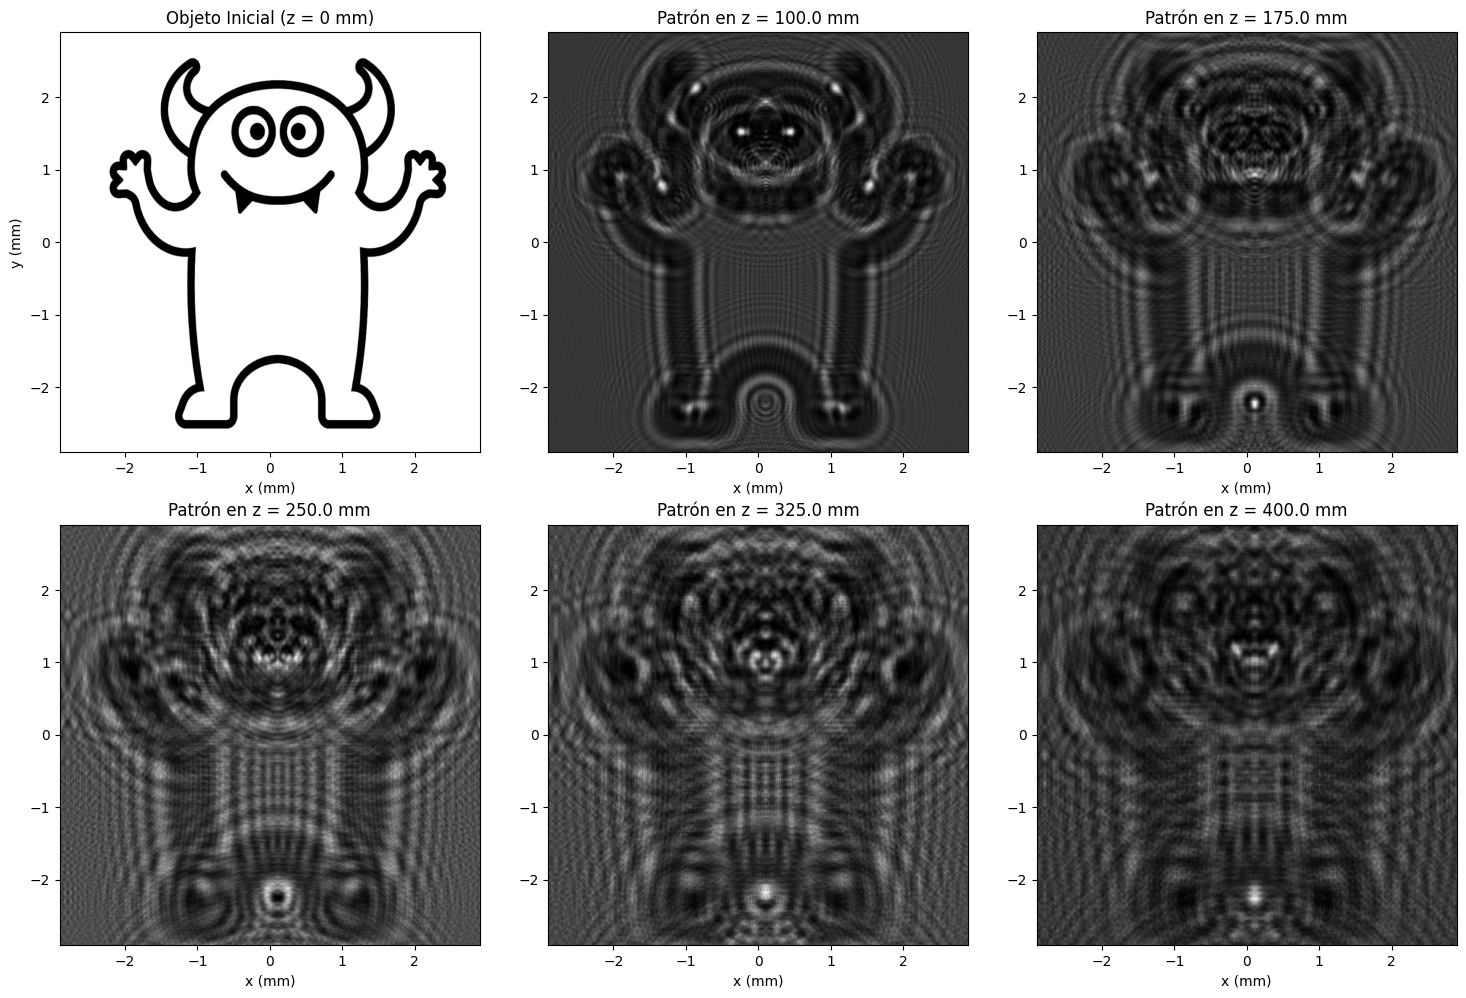

In [ ]:

# --- SCRIPT PRINCIPAL PARA CALCULAR Y GRAFICAR LA DIFRACCIÓN ---

# --- 1. Parámetros de la simulación ---
# Nombre del archivo que contiene la transmitancia del objeto.
nombre_archivo_objeto = 'Transm_E04.png'
# Longitud de onda en milímetros (633 nm -> 633e-6 mm).
lambda_mm = 633e-6
# Dimensión física transversal del objeto en milímetros.
tamano_fisico_mm = 5.8

# --- 2. Cargar y preparar el objeto (campo inicial) ---
# Cargar la imagen en escala de grises.
campo_inicial = cv2.imread(nombre_archivo_objeto, cv2.IMREAD_GRAYSCALE)

# Verificar si la imagen se cargó correctamente.
if campo_inicial is None:
    raise FileNotFoundError(f"Error: No se pudo cargar la imagen '{nombre_archivo_objeto}'.")

# Normalizar la imagen para que sus valores estén entre 0 y 1.
campo_inicial = campo_inicial / 255.0

# Obtener las dimensiones de la simulación a partir de la imagen.
ny, nx = campo_inicial.shape
# Definir los límites del espacio físico.
x_min, x_max = -tamano_fisico_mm / 2, tamano_fisico_mm / 2
y_min, y_max = -tamano_fisico_mm / 2, tamano_fisico_mm / 2

# --- 3. Definir las distancias de propagación ---
# Se crearán 5 distancias espaciadas uniformemente entre 10 cm (100 mm) y 40 cm (400 mm).
distancias_mm = np.linspace(100, 400, 5)

print("Iniciando simulación de difracción...")
print(f"Objeto: '{nombre_archivo_objeto}', Tamaño físico: {tamano_fisico_mm} mm")
print("Distancias a calcular:", [f"{d:.1f} mm" for d in distancias_mm])

# --- 4. Preparar la figura para las gráficas ---
# Se crea una figura con 2 filas y 3 columnas para mostrar 6 imágenes.
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
# Se aplana el array de ejes para acceder a ellos como una lista (axes[0], axes[1], ...).
axes = axes.ravel()

# --- 5. Graficar el objeto inicial ---
# Mostrar la imagen original en el primer subplot.
axes[0].imshow(campo_inicial, cmap='gray', extent=[x_min, x_max, y_min, y_max])
axes[0].set_title("Objeto Inicial (z = 0 mm)")
axes[0].set_xlabel("x (mm)")
axes[0].set_ylabel("y (mm)")

# --- 6. Bucle para calcular y graficar la difracción en cada distancia ---
for i, z in enumerate(distancias_mm):
    print(f"Calculando patrón de difracción para z = {z:.1f} mm...")

    # Llamada a la función de propagación.
    # Se usa el espectro angular por ser más preciso para este rango de distancias.
    patron_difraccion = fft_propagacion_espectro_angular(
        campo_inicial=campo_inicial,
        nx=nx, ny=ny,
        x_min=x_min, x_max=x_max,
        y_min=y_min, y_max=y_max,
        distancia_z=z,
        lambda_=lambda_mm
    )

    # Mostrar el resultado en el subplot correspondiente (del 1 al 5).
    ax = axes[i + 1]
    ax.imshow(patron_difraccion, cmap='gray', extent=[x_min, x_max, y_min, y_max])
    ax.set_title(f"Patrón en z = {z:.1f} mm")
    ax.set_xlabel("x (mm)")

# Ajustar el espaciado entre gráficas y mostrar la ventana.
plt.tight_layout()
plt.show()
